In [248]:
import os
import xarray as xr
import jsmetrics as js

import sys
sys.path.append('/home/links/ct715/eddy_feedback/')
import functions.data_wrangling as data 

### CanESM5

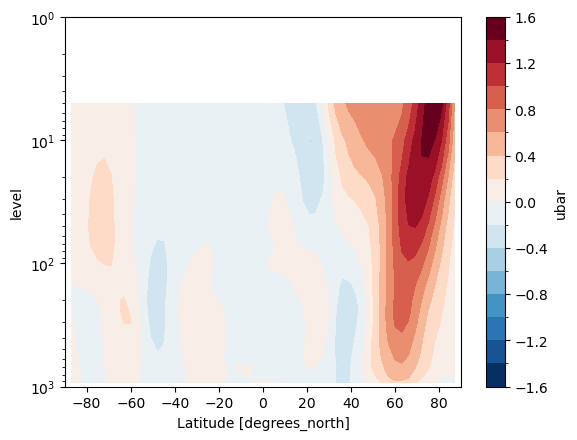

In [249]:
can_pd = xr.open_mfdataset('/gws/nopw/j04/arctic_connect/cturrell/PAMIP_data/processed_monthly/1.1_pdSST-pdSIC/CanESM5*.nc',
                           parallel=True, chunks={'time':12, 'ens_ax':50})

can_futArc = xr.open_mfdataset('/gws/nopw/j04/arctic_connect/cturrell/PAMIP_data/processed_monthly/1.6_pdSST-futArcSIC/CanESM5*.nc',
                          parallel=True, chunks={'time':12, 'ens_ax':50})

can_pd = data.seasonal_mean(can_pd, season='djf')
can_futArc = data.seasonal_mean(can_futArc, season='djf')

# take averages
if 'ens_ax' in can_pd.dims:
    can_pd = can_pd.mean('ens_ax')
    can_futArc = can_futArc.mean('ens_ax')
    diff = can_pd.ubar - can_futArc.ubar
    diff.mean('time').plot.contourf(levels=20, yincrease=False, yscale='log')
else:
    can_pd = can_pd.groupby('time.month').mean('time')
    can_futArc = can_futArc.groupby('time.month').mean('time')
    diff = can_pd.ubar - can_futArc.ubar
    diff.plot.contourf(levels=20, yincrease=False, yscale='log')

In [250]:
# Add the longitude coordinate
lon = xr.DataArray([0], dims="lon", coords={"lon": [0]})
# Use xr.concat to add the new lon dimension to each DataArray
can_pd = xr.concat([can_pd], dim=lon)
can_futArc = xr.concat([can_futArc], dim=lon)

# rename variables required for function
can_pd, can_futArc = can_pd.rename({'level': 'plev', 'ubar':'ua'}), can_futArc.rename({'level': 'plev', 'ubar':'ua'})

# Subset dataset to range used in original methodology (850 hPa &  30-70N))):
ua_pd = can_pd.sel(plev=850, lat=slice(30, 70))
ua_futArc = can_futArc.sel(plev=850, lat=slice(30, 70))

# Run statistic:
z18_pd = js.jet_statistics.zappa_et_al_2018(ua_pd, lon_resolution=3)
z18_futArc = js.jet_statistics.zappa_et_al_2018(ua_futArc, lon_resolution=3)

In [251]:
print(z18_pd.jet_lat.values)
print(z18_futArc.jet_lat.values)

z18_futArc.jet_lat.values - z18_pd.jet_lat.values

[44.17528332]
[43.49104109]


array([-0.68424223])

# All Models

Need to add EFP calculations and add to ds.

In [252]:
file_path = '/gws/nopw/j04/arctic_connect/cturrell/PAMIP_data/processed_monthly/'
file_names = os.listdir(file_path+'1.6_pdSST-futArcSIC')

# shorter version of above:
model_names = [os.path.basename(f).split('_')[0] for f in file_names]
# model_names.remove('FGOALS-f3-L')
print(model_names)

['CESM1-WACCM-SC', 'CESM2', 'CNRM-CM6-1', 'CanESM5', 'EC-EARTH3', 'FGOALS-f3-L', 'HadGEM3-GC31-MM', 'IPSL-CM6A-LR', 'MIROC6', 'NorESM2-LM', 'OpenIFS-159', 'OpenIFS-511']


In [253]:
import cftime

def convert_to_360_day_calendar(ds):
    # Extract the time variable
    time = ds['time'].values
    
    # Convert to cftime.datetime objects using a 360-day calendar
    # new_time = [cftime.Datetime360Day(t.year, t.month, t.day, t.hour, t.minute, t.second) for t in xr.cftime_range(start=time[0], periods=len(time), calendar='360_day')]
    new_time = [cftime.Datetime360Day(2000, 12, 1, 0, 0, 0, 0, has_year_zero=True)]
    
    # Replace the time coordinates in the dataset
    ds['time'] = new_time
    return ds

### pdSST-pdSIC

In [254]:
# # pull in model names and import data
# pd_models = [file_path+f'1.1_pdSST-pdSIC/{item}*.nc' for item in model_names]
# pd_data = [xr.open_mfdataset(pd) for pd in pd_models]

# Pull in model names and import data
pd_models = [file_path + f'1.1_pdSST-pdSIC/{item}*.nc' for item in model_names]
pd_data = []

for model, pd in zip(model_names, pd_models):
    ds = xr.open_mfdataset(pd, combine='by_coords')
    ds = ds.assign_coords(model_name=model)
    pd_data.append(ds)

# Now each dataset in pd_data has a record of its model name
# print(pd_data)

In [255]:
pd_jets = []
for model in pd_data:
    
    # take winter mean
    model = data.seasonal_mean(model, season='djf')
    model = model.rename({'level': 'plev', 'ubar': 'ua'})
    
    # one model ensemble members is done by time
    if 'ens_ax' in model.dims:
        model = model.mean('ens_ax')
    else:
        model = model.groupby('time.month').mean('time')
        model = model.rename({'month': 'time'})
        
    # subset data to consistency 
    model = model.sel(plev=850.)
    model = model.sel(lat=slice(30,70))
        
    # Add the longitude coordinate
    lon = xr.DataArray([0], dims="lon", coords={"lon": [0]})
    model = xr.concat([model], dim=lon)
    model = js.jet_statistics.zappa_et_al_2018(model, lon_resolution=3)
    
    model = convert_to_360_day_calendar(model)
    
    pd_jets.append(model)

print(len(pd_jets))
pd_jets[0]

12


<xarray.Dataset>
Dimensions:        (lon: 1, time: 1, lat: 14)
Coordinates:
    plev           float64 850.0
  * lon            (lon) int64 0
  * lat            (lat) int64 30 33 36 39 42 45 48 51 54 57 60 63 66 69
    model_name     <U14 'CESM1-WACCM-SC'
  * time           (time) object 2000-12-01 00:00:00
Data variables:
    ua             (lon, time, lat) float32 1.481 3.326 4.565 ... 0.6806 0.3896
    epfy           (lon, time, lat) float64 -6.889e+06 -8.287e+06 ... -8.724e+05
    divF           (lon, time, lat) float64 -5.879e-07 3.733e-08 ... 2.202e-06
    total_area_m2  (lat, lon) float64 9.636e+10 9.332e+10 ... 3.987e+10
    jet_lat        (time) float64 44.52
    jet_speed      (time) float64 6.248

In [256]:
pd_jet_lat = [ds['jet_lat'] for ds in pd_jets]
# pd_jet_lat[0]

# Optionally, you can concatenate these datasets along a new dimension if needed
combined_pd = xr.concat(pd_jet_lat, dim='model_name')
combined_pd

<xarray.DataArray 'jet_lat' (model_name: 12, time: 1)>
array([[44.52146212],
       [44.54832731],
       [41.79289779],
       [44.17528332],
       [43.46443577],
       [41.98974624],
       [43.70341665],
       [41.3313083 ],
       [41.34732593],
       [44.75005291],
       [43.25585737],
       [43.43882586]])
Coordinates:
    plev        float64 850.0
  * model_name  (model_name) <U15 'CESM1-WACCM-SC' 'CESM2' ... 'OpenIFS-511'
  * time        (time) object 2000-12-01 00:00:00

### pdSST-futArcSIC

In [257]:
# pull in model names and import data
futArc_models = [file_path+f'1.6_pdSST-futArcSIC/{item}*.nc' for item in model_names]
futArc_data = [xr.open_mfdataset(futArc) for futArc in futArc_models]

futArc_jets = []
for model in futArc_data:
    
    # take winter mean
    model = data.seasonal_mean(model, season='djf')
    model = model.rename({'level': 'plev', 'ubar': 'ua'})
    
    # one model ensemble members is done by time
    if 'ens_ax' in model.dims:
        model = model.mean('ens_ax')
    else:
        model = model.groupby('time.month').mean('time')
        model = model.rename({'month': 'time'})
        
    # subset data to consistency 
    model = model.sel(plev=850.)
    model = model.sel(lat=slice(30,70))
        
    # Add the longitude coordinate
    lon = xr.DataArray([0], dims="lon", coords={"lon": [0]})
    model = xr.concat([model], dim=lon)
    model = js.jet_statistics.zappa_et_al_2018(model, lon_resolution=3)
    
    model = convert_to_360_day_calendar(model)
    futArc_jets.append(model)

print(len(futArc_jets))
futArc_jets[0]

12


<xarray.Dataset>
Dimensions:        (lon: 1, time: 1, lat: 14)
Coordinates:
    plev           float64 850.0
  * lon            (lon) int64 0
  * lat            (lat) int64 30 33 36 39 42 45 48 51 54 57 60 63 66 69
  * time           (time) object 2000-12-01 00:00:00
Data variables:
    ua             (lon, time, lat) float32 1.59 3.454 4.694 ... 0.5086 0.2462
    epfy           (lon, time, lat) float64 -7.383e+06 -8.8e+06 ... -9.668e+05
    divF           (lon, time, lat) float64 -6.092e-07 6.26e-08 ... 2.319e-06
    total_area_m2  (lat, lon) float64 9.636e+10 9.332e+10 ... 3.987e+10
    jet_lat        (time) float64 44.09
    jet_speed      (time) float64 6.22

In [258]:
futArc_jet_lat = [ds['jet_lat'] for ds in futArc_jets]
# futArc_jet_lat[0]

# Optionally, you can concatenate these datasets along a new dimension if needed
combined_futArc = xr.concat(futArc_jet_lat, dim='model_name')
combined_futArc

<xarray.DataArray 'jet_lat' (model_name: 12, time: 1)>
array([[44.09147663],
       [43.70064989],
       [41.1145303 ],
       [43.49104109],
       [42.91124837],
       [41.59589152],
       [42.93560384],
       [41.06637264],
       [40.78982221],
       [44.33529954],
       [42.74242474],
       [42.77603586]])
Coordinates:
    plev     float64 850.0
  * time     (time) object 2000-12-01 00:00:00
Dimensions without coordinates: model_name

In [259]:
diff = combined_futArc - combined_pd
diff = diff.mean('time')
diff

<xarray.DataArray 'jet_lat' (model_name: 12)>
array([-0.42998549, -0.84767742, -0.67836748, -0.68424223, -0.5531874 ,
       -0.39385472, -0.76781281, -0.26493567, -0.55750371, -0.41475337,
       -0.51343264, -0.66279   ])
Coordinates:
    plev        float64 850.0
  * model_name  (model_name) <U15 'CESM1-WACCM-SC' 'CESM2' ... 'OpenIFS-511'

In [260]:
diff.sel(model_name='CanESM5')

<xarray.DataArray 'jet_lat' ()>
array(-0.68424223)
Coordinates:
    plev        float64 850.0
    model_name  <U15 'CanESM5'

In [261]:
# NH_jet_shifts = [diff[i].values[0] for i in range(len(diff))]
# NH_jet_shifts

In [262]:
import pandas as pd

# Create DataFrame
js_data = {'Model': diff['model_name'], 'NH jet shift': diff}
jet_shifts = pd.DataFrame(js_data)

jet_shifts

,Model,NH jet shift
0,CESM1-WACCM-SC,-0.429985
1,CESM2,-0.847677
2,CNRM-CM6-1,-0.678367
3,CanESM5,-0.684242
4,EC-EARTH3,-0.553187
5,FGOALS-f3-L,-0.393855
6,HadGEM3-GC31-MM,-0.767813
7,IPSL-CM6A-LR,-0.264936
8,MIROC6,-0.557504
9,NorESM2-LM,-0.414753


In [263]:
efp_values = pd.read_csv('efp_values.csv')
# efp_values = efp_values.drop(columns='SH Feedback (JAS)')

# drop models
drop_missing_models = ['E3SMv1', 'ECHAM6.3_AWI', 'HadGEM3-GC31-LL']
efp_values = efp_values[~efp_values['Model'].isin(drop_missing_models)]
efp_values = efp_values.reset_index(drop=True)
efp_values

,Model,NH Feedback (DJF),SH Feedback (JAS)
0,CanESM5,0.4255,0.4634
1,CESM2,0.3978,0.3548
2,CNRM-CM6-1,0.2733,0.2386
3,EC-EARTH3,0.3365,0.3480
4,FGOALS-f3-L,0.2621,0.1420
5,HadGEM3-GC31-MM,0.3616,0.3474
6,IPSL-CM6A-LR,0.3099,0.2262
7,MIROC6,0.2469,0.3547
8,NorESM2-LM,0.3354,0.3837
9,OpenIFS-159,0.3636,0.3588


In [264]:
df_merged = pd.merge(efp_values, jet_shifts, on='Model')
df_merged

,Model,NH Feedback (DJF),SH Feedback (JAS),NH jet shift
0,CanESM5,0.4255,0.4634,-0.684242
1,CESM2,0.3978,0.3548,-0.847677
2,CNRM-CM6-1,0.2733,0.2386,-0.678367
3,EC-EARTH3,0.3365,0.3480,-0.553187
4,FGOALS-f3-L,0.2621,0.1420,-0.393855
5,HadGEM3-GC31-MM,0.3616,0.3474,-0.767813
6,IPSL-CM6A-LR,0.3099,0.2262,-0.264936
7,MIROC6,0.2469,0.3547,-0.557504
8,NorESM2-LM,0.3354,0.3837,-0.414753
9,OpenIFS-159,0.3636,0.3588,-0.513433


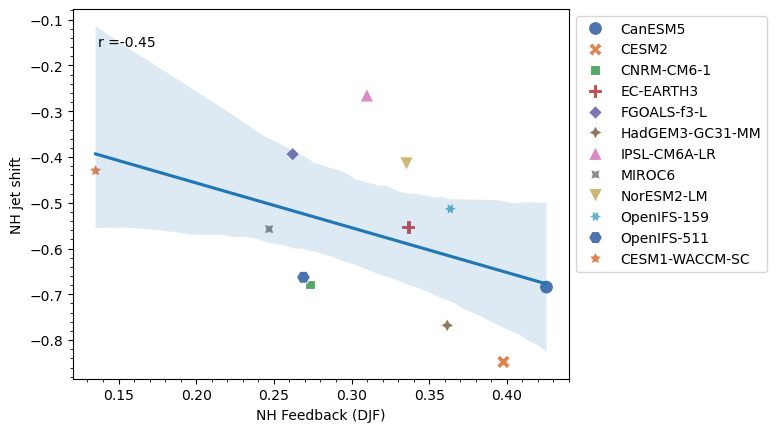

In [265]:
import seaborn as sns
import matplotlib.pyplot as plt 
import scipy as sp

plt.figure()
# sns.regplot(data=df_merged, x='NH Feedback (DJF)', y='NH jet shift', scatter_kws={'color': 'white'}, line_kws={"color": "gray"})
scatter_plot = sns.scatterplot(
    x='NH Feedback (DJF)', 
    y='NH jet shift', 
    hue='Model', 
    style='Model', 
    data=df_merged, 
    palette='deep', 
    markers=True, 
    s=100
)

# Plot the regression line
sns.regplot(
    x='NH Feedback (DJF)', 
    y='NH jet shift', 
    data=df_merged, 
    scatter=False, 
    ax=scatter_plot
)

# Insert Pearson's correlation
r, p = sp.stats.pearsonr(x=df_merged['NH Feedback (DJF)'], y=df_merged['NH jet shift'])
ax = plt.gca()
plt.text(.05, .9, "r ={:.2f}".format(r), transform=ax.transAxes)

# plt.xlim([0,0.5])
# plt.ylim([0,0.5])

plt.minorticks_on()
plt.legend(bbox_to_anchor=(1,1))
plt.show()

In [266]:
# df_merged.to_csv('df_merged.csv', index=False)

# Fabricate Data

In [282]:
fabricate = [-0.44, -0.64, -0.60, -0.76, -0.48, -0.32, -0.81, -0.47, -0.39, -0.40, -0.51, -0.39]

# Create DataFrame
fab_data = {'Model': diff['model_name'], 'NH jet shift': fabricate}
jet_shifts = pd.DataFrame(fab_data)

# jet_shifts
df_fabricated = pd.merge(efp_values, jet_shifts, on='Model')
df_fabricated

,Model,NH Feedback (DJF),SH Feedback (JAS),NH jet shift
0,CanESM5,0.4255,0.4634,-0.76
1,CESM2,0.3978,0.3548,-0.64
2,CNRM-CM6-1,0.2733,0.2386,-0.60
3,EC-EARTH3,0.3365,0.3480,-0.48
4,FGOALS-f3-L,0.2621,0.1420,-0.32
5,HadGEM3-GC31-MM,0.3616,0.3474,-0.81
6,IPSL-CM6A-LR,0.3099,0.2262,-0.47
7,MIROC6,0.2469,0.3547,-0.39
8,NorESM2-LM,0.3354,0.3837,-0.40
9,OpenIFS-159,0.3636,0.3588,-0.51


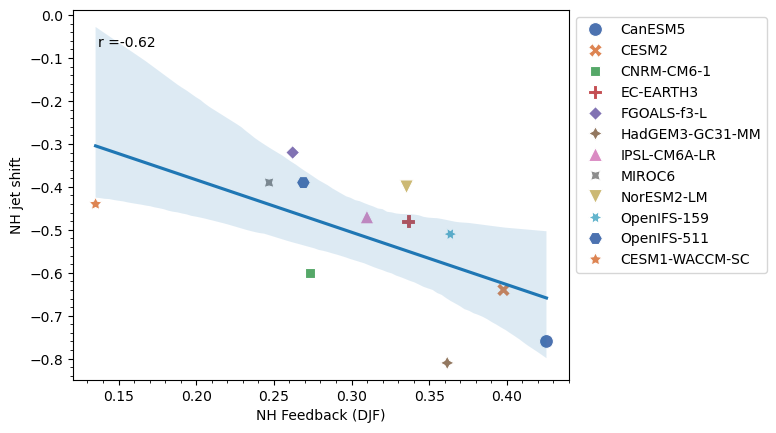

In [283]:
import seaborn as sns
import matplotlib.pyplot as plt 
import scipy as sp

plt.figure()
# sns.regplot(data=df_fabricated, x='NH Feedback (DJF)', y='NH jet shift', scatter_kws={'color': 'white'}, line_kws={"color": "gray"})
scatter_plot = sns.scatterplot(
    x='NH Feedback (DJF)', 
    y='NH jet shift', 
    hue='Model', 
    style='Model', 
    data=df_fabricated, 
    palette='deep', 
    markers=True, 
    s=100
)

# Plot the regression line
sns.regplot(
    x='NH Feedback (DJF)', 
    y='NH jet shift', 
    data=df_fabricated, 
    scatter=False, 
    ax=scatter_plot
)

# Insert Pearson's correlation
r, p = sp.stats.pearsonr(x=df_fabricated['NH Feedback (DJF)'], y=df_fabricated['NH jet shift'])
ax = plt.gca()
plt.text(.05, .9, "r ={:.2f}".format(r), transform=ax.transAxes)

# plt.xlim([0,0.5])
# plt.ylim([0,0.5])

plt.minorticks_on()
plt.legend(bbox_to_anchor=(1,1))
plt.show()

In [285]:
# df_fabricated.to_csv('fabricated_data.csv', index=False)

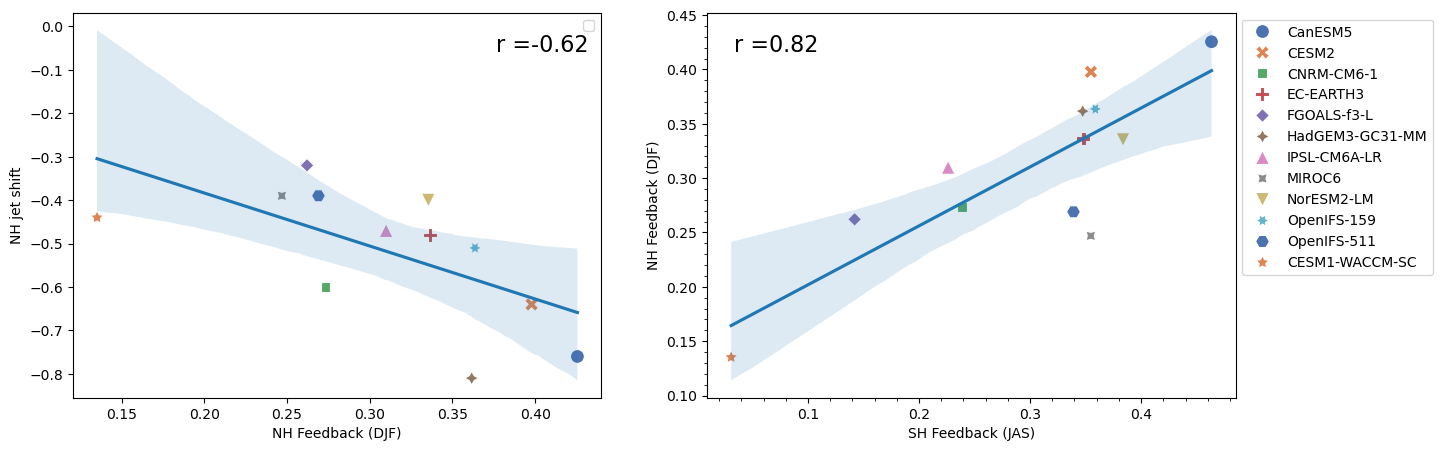

In [315]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))

## FIGURE 1

scatter_plot1 = sns.scatterplot(
    x='NH Feedback (DJF)', 
    y='NH jet shift', 
    hue='Model', 
    style='Model', 
    data=df_fabricated, 
    palette='deep', 
    markers=True, 
    s=100,
    ax=ax1
)
# Plot the regression line
sns.regplot(
    x='NH Feedback (DJF)', 
    y='NH jet shift', 
    data=df_fabricated, 
    scatter=False, 
    ax=scatter_plot1
)
ax1.legend([])

# Insert Pearson's correlation
r1, p1 = sp.stats.pearsonr(x=df_fabricated['NH Feedback (DJF)'], y=df_fabricated['NH jet shift'])
ax = plt.gca()
plt.text(-0.4, .9, "r ={:.2f}".format(r1), transform=ax.transAxes, fontsize=16)


## FIGURE 2

scatter_plot2 = sns.scatterplot(
    y='NH Feedback (DJF)', 
    x='SH Feedback (JAS)', 
    hue='Model', 
    style='Model', 
    data=df_fabricated, 
    palette='deep', 
    markers=True, 
    s=100,
    ax=ax2
)
# Plot the regression line
sns.regplot(
    y='NH Feedback (DJF)', 
    x='SH Feedback (JAS)', 
    data=df_fabricated, 
    scatter=False, 
    ax=scatter_plot2
)


# Insert Pearson's correlation
r2, p2 = sp.stats.pearsonr(x=df_fabricated['SH Feedback (JAS)'], y=df_fabricated['NH Feedback (DJF)'])
ax = plt.gca()
plt.text(.05, .9, "r ={:.2f}".format(r2), transform=ax.transAxes, fontsize=16)

plt.minorticks_on()
plt.legend(bbox_to_anchor=(1,1))
plt.show()